In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import scipy.optimize as spo
import scipy.special as sps
import math
from matplotlib.gridspec import GridSpec


## This contains the whole body of GonzNuevoClust and clust_dist class

In [36]:
def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

def plaw_pspec_to_2pcf(const, delta):
    alpha = 3 - delta
    A = const * (sps.gamma(alpha/2))/ (np.power(2, 1 - alpha/2) * sps.gamma((3 - alpha)/2))
    return A, alpha

def plaw_2pcf_to_pspec(A, alpha):
    delta = 3 - alpha
    const = A * (np.power(2, 1 - alpha/2) * sps.gamma((3 - alpha)/2)) / (sps.gamma(alpha/2))
    return const, delta

class clust_dist:
    def __init__(self, N_side, dx) -> None:
        self.N_side = N_side
        self.dx = dx
        #dk of the fourier lattice.
        self.dk = 2 * np.pi/(self.N_side * self.dx)

    def initialize_pois(self, n_bar):
        self.n_bar = n_bar
        
        #Creating a box with N_side^3 dimension and fill it with poisson random numbers with lambda=n_bar.
        self.box_p = np.random.poisson(lam=n_bar, size=(self.N_side, self.N_side, self.N_side))
        print("Poisson lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - n_bar)/n_bar
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")

    def initialize_gauss(self, lam, sig):
        self.n_bar = lam

        #Creating a box with N_side^3 dimension and fill it with Gaussian random numbers with lambda=lam and sigma = sig.
        self.box_p = np.random.normal(loc=lam, scale=sig, size=(self.N_side, self.N_side, self.N_side))
        print("Gaussian lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - lam)/lam
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")
    
    def calc_powerspec_pois(self, k_intervals):
        #Finding the powerspectrum here. Iterate through the k_for_P and find the index of modk_grid with k
        #that falls between and find power spectrum pk.
        powerspec = np.zeros(len(k_intervals)-1)
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            powerspec[i] = np.average(np.absolute(self.box_delk[np.where((self.modk_grid >= k1) & (self.modk_grid < k2))]) ** 2)
        powerspec = powerspec/((self.N_side * self.dx)**3) * np.power(np.sqrt(2 * np.pi), 3)

        return powerspec
    
    def calc_powerspec_clust(self, k_intervals):
        powerspec = np.zeros(len(k_intervals)-1)
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            powerspec[i] = np.average(np.absolute(self.box_delk_clust[np.where((self.modk_grid >= k1) & (self.modk_grid < k2))]) ** 2)
        powerspec = powerspec/((self.N_side * self.dx)**3) * np.power(np.sqrt(2 * np.pi), 3)

        return powerspec
    
    def update_k_intervals(self, k_intervals):
        ##Assert that the given k_intervals have appropriate k_min and k_max
        assert k_intervals[0] == self.k_min
        # assert k_intervals[-1] == self.k_max
        #updating the k_intervals
        self.k_intervals = np.copy(k_intervals)
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)

    def make_clust_dist(self, powerspec_clust, k_intervals):
        #Making the new box_delk_clust. Right now, whenever we call this method, the previous box_delk_clust if any
        #will be erased.
        self.box_delk_clust = np.copy(self.box_delk)
        #Modifying the box-delk_clust to have the input powerspectrum.
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            temp_ind = np.where((self.modk_grid >= k1) & (self.modk_grid < k2))
            self.box_delk_clust[temp_ind] = self.box_delk[temp_ind] * (np.sqrt(powerspec_clust[i] + self.powerspec_pois[i])) / np.sqrt(self.powerspec_pois[i])
        #Defining the input powerspec as the powerspec of box_delk_clust
        self.powerspec_clust = np.copy(powerspec_clust)
        self.update_k_intervals(k_intervals)
        #Now we need to inverse fourier transfor box_delk_clust to get box_delx_clust
        self.box_delx_clust = np.fft.ifftn(self.box_delk_clust, norm='ortho')
        temp_factor = np.power(self.dk * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delx_clust = temp_factor * self.box_delx_clust
        #Create the new n(x) array.
        self.box_GN = self.n_bar * (1 + self.box_delx_clust)
        print("Made the clustered distribution.")

    def make_clust_dist_from_plaw_pspec(self, const, delta, k_intervals):
        if not np.array_equal(k_intervals, self.k_intervals):
            self.update_k_intervals(k_intervals)
        temp_pk = const * np.power(self.k_intervals_mid, -delta)
        self.make_clust_dist(temp_pk, self.k_intervals) 

    def calc_2pcorrfunc_clust(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)
        #defining the x intervals in which we calculate the 2pcf
        self.x_intervals_mid = np.arange(x_min_int, x_max_int) * self.dx #I chose only even
        self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(np.arange(x_min_int, x_max_int)):
            self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
        print("2 point correlation function calculated.")

    def calc_2pcorrfunc_clust2(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)

        box_r = np.random.poisson(lam=self.n_bar, size=(self.N_side, self.N_side, self.N_side))
        bins = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = (bins[:-1] + bins[1:])/2 * self.dx
        x1, y1, z1 = np.asarray(np.meshgrid(np.arange(self.N_side), np.arange(self.N_side), np.arange(self.N_side), indexing='xy'), dtype='float')
        x1 = x1.flatten()
        y1 = y1.flatten()
        z1 = z1.flatten()
        weights1 = np.asarray(self.box_GN.flatten(), dtype='float')

        result_DD_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

        weights2 = np.asarray(box_r.flatten(), dtype='float')
        x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(self.N_side), np.arange(self.N_side), np.arange(self.N_side), indexing='xy'), dtype='float')
        x_r = x_r.flatten()
        y_r = y_r.flatten()
        z_r = z_r.flatten()
        result_RR_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

        result_DR_GN = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)
        #Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
        #We need normalisation also, which is the total number of pairs.
        DD_count_GN = (result_DD_GN['npairs']*result_DD_GN['weightavg'])/2
        DR_count_GN = result_DR_GN['npairs']*result_DR_GN['weightavg']
        RR_count_GN = (result_RR_GN['npairs']*result_RR_GN['weightavg'])/2
        DD_total_GN = (np.sum(weights1) * (np.sum(weights1) - 1))/2
        RR_total_GN = (np.sum(weights2) * (np.sum(weights2) - 1))/2
        DR_total_GN = (np.sum(weights1) * np.sum(weights2))

        self._2pcorrfunc = (DD_count_GN/DD_total_GN - 2 * DR_count_GN/DR_total_GN + RR_count_GN/RR_total_GN)/(RR_count_GN/RR_total_GN)

    def fit_2pcf_clust(self):
        temp_popt, temp_pcov = spo.curve_fit(pow_func, self.x_intervals_mid, self._2pcorrfunc)
        self._2pcf_fit_alpha = temp_popt[1]
        self._2pcf_fit_A = temp_popt[0]
        print("The measured 2pcf of box_delx_clust is fitted to a power law")

    def show_delx_dist(self):
        fig, ax = plt.subplots()
        ax.hist((self.box_delx_clust).flatten(), bins=100)
        ax.hist((self.box_delx).flatten(), bins=100)
        return fig, ax
    
    def show_powerspecs(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
        ax1.plot(self.k_intervals_mid, self.powerspec_pois, '-*')
        ax1.set_ylabel(r'$P(K)$')
        ax1.set_xlabel(r'$k$')
        ax1.set_title('power spectrum of poisson lattice')
        ax1.axhline((1/self.n_bar) * (self.dx / np.sqrt(2 * np.pi))**3, color ='k', label="expected")

        ax2.plot(self.k_intervals_mid, self.calc_powerspec_clust(self.k_intervals), '-*', label="measured")
        ax2.plot(self.k_intervals_mid, self.powerspec_clust, '-*', label="input")
        ax2.set_ylabel(r'$P(K)$')
        ax2.set_xlabel(r'$k$')
        ax2.set_title('power spectrum of clustered lattice')
        ax1.legend()
        ax2.legend()
        return fig, (ax1, ax2)

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_25573/3246168309.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law


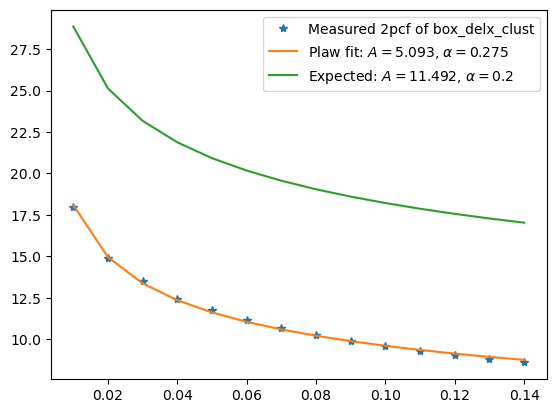

In [86]:
N_side = 512
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 2.8

sample_clust = clust_dist(N_side, dx)
sample_clust.initialize_pois(n_bar)

sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals) 

sample_clust.calc_2pcorrfunc_clust(1.0 * dx, 15 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
                label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
plt.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
            label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

## Tests happen here

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_392963/2981598641.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law


Text(0.5, 0.98, 'Input power spectrum and resulting 2pcf')

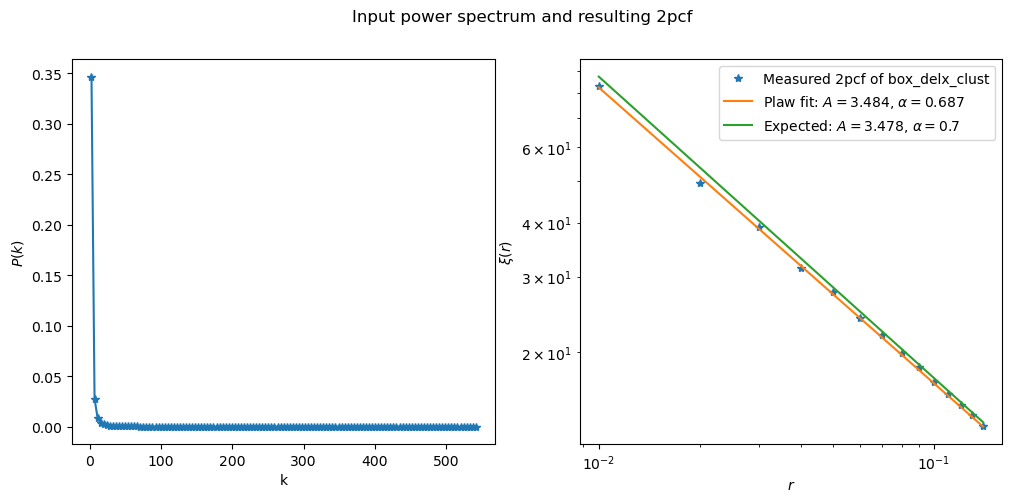

In [37]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 2.3

sample_clust = clust_dist(N_side, dx)
sample_clust.initialize_pois(n_bar)
# print(sample_clust.k_intervals)
# new_k_intervals = np.concatenate((np.linspace(sample_clust.k_min, (sample_clust.k_max)/2, N_side//4), np.linspace((sample_clust.k_max)/2, sample_clust.k_max, N_side//2)))
# new_k_intervals = np.linspace(sample_clust.k_min, sample_clust.k_max, N_side)
# sample_clust.update_k_intervals(new_k_intervals)
# print(sample_clust.k_intervals)
# k_intervals = np.linspace(sample_clust.k_min, sample_clust.k_max, sample_clust.N_side//2)
# k_intervals_mid = (k_intervals[:-1] + k_intervals[1:])/2
# powerspec = np.exp(-np.power(k_intervals_mid/50, 2))


sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals)
# sample_clust.make_clust_dist(powerspec, k_intervals) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(sample_clust.k_intervals_mid, sample_clust.powerspec_clust, '-*', label="Input power spectrum")

sample_clust.calc_2pcorrfunc_clust(1 * dx, 15 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

ax2.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
ax2.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
                label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
ax2.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
            label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$P(k)$')
ax2.set_ylabel(r'$\xi(r)$')
ax2.set_xlabel(r'$r$')
ax2.legend()
fig.suptitle("Input power spectrum and resulting 2pcf")

(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'power spectrum of poisson lattice'}, xlabel='$k$', ylabel='$P(K)$'>,
  <Axes: title={'center': 'power spectrum of clustered lattice'}, xlabel='$k$', ylabel='$P(K)$'>))

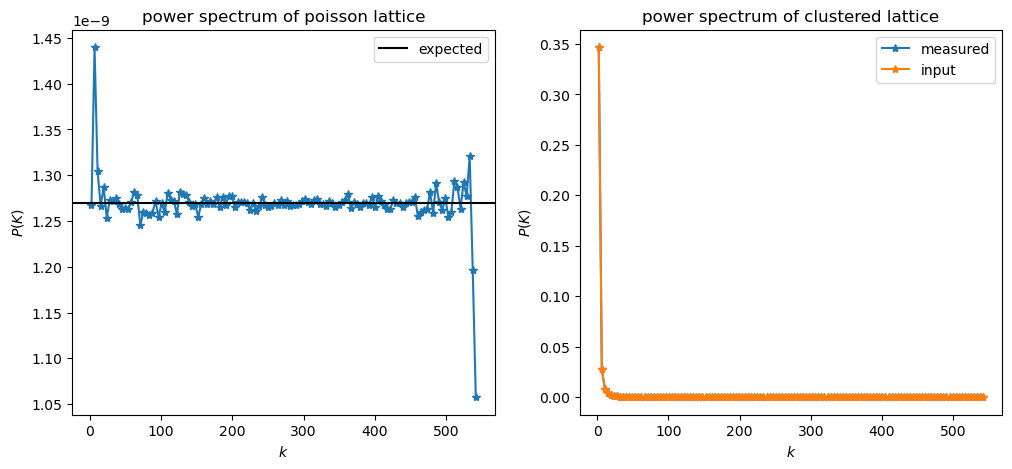

In [38]:
sample_clust.show_powerspecs()

In [24]:
1/50 * sample_clust.dx**3 /(np.sqrt(2 * np.pi) **3)

1.26987271868482e-09

## Test on 2pcf measurement

In [26]:
def calc_2pcorrfunc_clust3(self, x_min, x_max):
    assert x_min > 0
    assert x_max > x_min
    # assert issubclass(x_intervals_int.dtype.int, np.integer)
    # min and max integer between given interval
    x_min_int = math.ceil(x_min/self.dx)
    x_max_int = math.ceil(x_max/self.dx)
    #defining the x intervals in which we calculate the 2pcf
    self.x_intervals_mid = np.arange(x_min_int, x_max_int) * self.dx
    self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
    for i, temp_x in enumerate(np.arange(x_min_int, x_max_int)):
        self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:self.N_side-temp_x,:]) * (self.box_delx_clust[:, temp_x:,:]))/ (self.N_side** 3)
    print("2 point correlation function calculated.")

/tmp/ipykernel_25573/2389657203.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:self.N_side-temp_x,:]) * (self.box_delx_clust[:, temp_x:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law


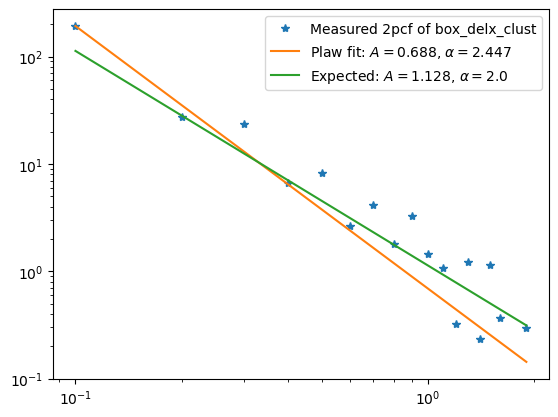

In [27]:
calc_2pcorrfunc_clust3(sample_clust, 1 * dx, 20 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
                label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
plt.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
            label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
plt.xscale('log')
plt.yscale('log')
plt.legend()

## Test on averaging various small sides run

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.


/tmp/ipykernel_2247003/1946390989.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made t

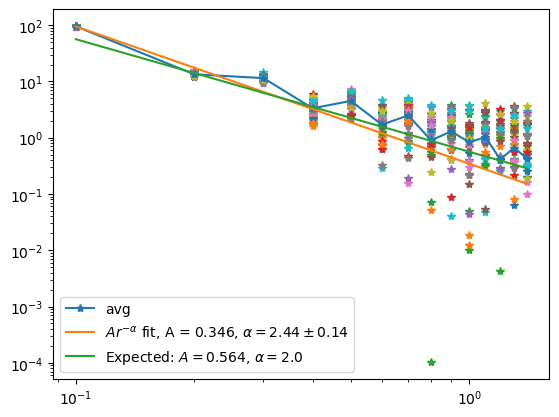

In [125]:
N_side = 64
dx = 0.1
n_bar = 50
const_of_pk = 1.0
delta_of_pk = 1.0
x_min = 1.0 * dx
x_max = 15.0 * dx
iter_n = 50

temp_corr = np.zeros((iter_n, len(np.arange(math.ceil(x_min/dx), math.ceil(x_max/dx)))))
for i in range(iter_n):
    sample_clust_32 = clust_dist(N_side, dx, n_bar)

    sample_clust_32.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust_32.k_intervals)

    sample_clust_32.calc_2pcorrfunc_clust(x_min, x_max)

    temp_corr[i] = sample_clust_32._2pcorrfunc
    plt.plot(sample_clust_32.x_intervals_mid, temp_corr[i], '*')

temp_corr_avg = np.average(temp_corr, axis=0)
plt.plot(sample_clust_32.x_intervals_mid, temp_corr_avg, '-*', label="avg")

temp_popt, temp_pcov = spo.curve_fit(pow_func, sample_clust_32.x_intervals_mid, temp_corr_avg)

plt.plot(sample_clust_32.x_intervals_mid, pow_func(sample_clust_32.x_intervals_mid, temp_popt[0], temp_popt[1]), label=r'$Ar^{{-\alpha}}$ fit, A = {}, $\alpha = {}\pm{}$'.format \
         (np.round(temp_popt[0],3), np.round(temp_popt[1],3),np.round(np.sqrt(temp_pcov[1,1]), 2)))

# sample_clust_32.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

# plt.plot(sample_clust_32.x_intervals_mid, sample_clust_32._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
# plt.plot(sample_clust_32.x_intervals_mid, sample_clust_32._2pcf_fit_A * np.power(sample_clust_32.x_intervals_mid, -sample_clust_32._2pcf_fit_alpha), \
#                 label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust_32._2pcf_fit_A,3), np.round(sample_clust_32._2pcf_fit_alpha,3)))
plt.plot(sample_clust_32.x_intervals_mid, exp_A * np.power(sample_clust_32.x_intervals_mid, -exp_alpha), \
             label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
plt.xscale('log')
plt.yscale('log')
plt.legend()

## alpha delta relation

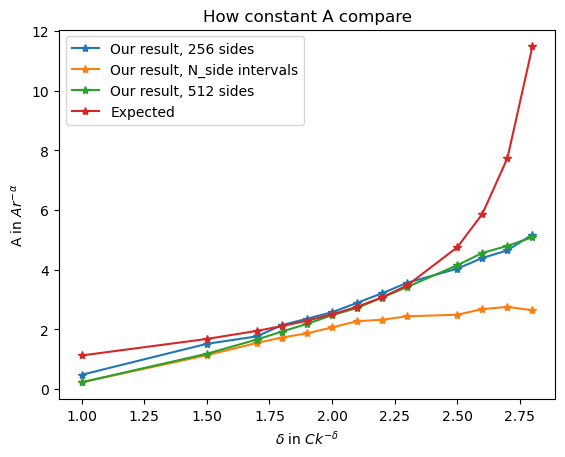

In [87]:
temp_delta = [1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.6, 2.7, 2.8]
temp_A = [0.48, 1.518, 1.769, 2.146, 2.361, 2.578, 2.893, 3.214, 3.566, 4.039, 4.396, 4.652, 5.183]
temp_alpha = [2.463, 1.624, 1.36, 1.239, 1.121, 1.008, 0.889, 0.777, 0.682, 0.508, 0.429, 0.369, 0.298]
temp_A_exp, temp_alpha_exp = np.vectorize(plaw_pspec_to_2pcf)(2.0, temp_delta)
temp_alpha_Nside = [2.464, 1.643, 1.388, 1.271, 1.162, 1.049 , 0.94, 0.849, 0.755 , 0.594, 0.505, 0.431, 0.377]
temp_A_Nside = [0.228, 1.137, 1.549, 1.73, 1.868, 2.071, 2.276, 2.327, 2.441, 2.494, 2.682, 2.757, 2.644]
temp_alpha_512 = [2.462, 1.635, 1.373, 1.248, 1.129, 1.012, 0.905, 0.794, 0.689, 0.498, 0.411, 0.341, 0.275]
temp_A_512 = [0.229, 1.186, 1.663, 1.93, 2.188, 2.479, 2.721, 3.071, 3.425, 4.154, 4.566, 4.803, 5.093]
plt.plot(temp_delta, temp_A, '-*', label="Our result, 256 sides")
plt.plot(temp_delta, temp_A_Nside, '-*', label="Our result, N_side intervals")
plt.plot(temp_delta, temp_A_512, '-*', label="Our result, 512 sides")
plt.plot(temp_delta, temp_A_exp, '-*', label="Expected")
plt.ylabel(r"A in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("How constant A compare")
plt.legend()

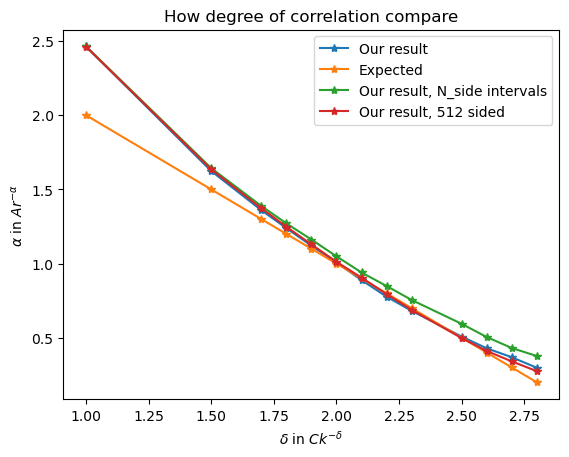

In [88]:
plt.plot(temp_delta, temp_alpha, '-*', label="Our result")
plt.plot(temp_delta, temp_alpha_exp, '-*', label="Expected")
plt.plot(temp_delta, temp_alpha_Nside, '-*', label="Our result, N_side intervals")
plt.plot(temp_delta, temp_alpha_512, '-*', label="Our result, 512 sided")
plt.ylabel(r"$\alpha$ in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("How degree of correlation compare")
plt.legend()

## Tests with other forms of power spectrum

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_147676/3246168309.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.


Text(0.5, 0.98, 'Input power spectrum and resulting 2pcf')

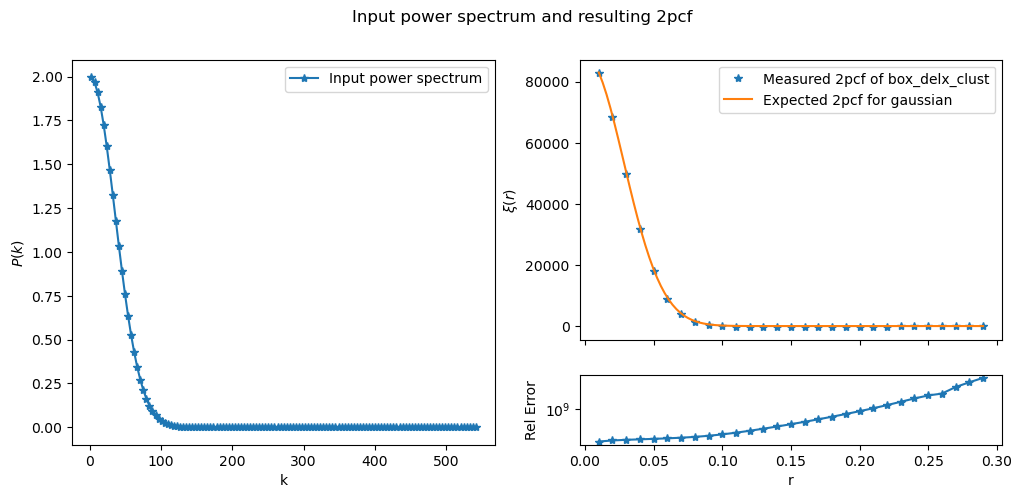

In [4]:
N_side = 256
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 2.3

def gauss_expect(x, A, k0):
    return np.exp(-np.power(k0 * (x)/2, 2)) * A * np.power(np.pi * k0 **2, 3/2) / np.power(2 * np.pi, 3/2)
gauss_expect = np.vectorize(gauss_expect)

sample_clust = clust_dist(N_side, dx)
sample_clust.initialize_pois(n_bar)
# print(sample_clust.k_intervals)
# new_k_intervals = np.concatenate((np.linspace(sample_clust.k_min, (sample_clust.k_max)/2, N_side//4), np.linspace((sample_clust.k_max)/2, sample_clust.k_max, N_side//2)))
# new_k_intervals = np.linspace(sample_clust.k_min, sample_clust.k_max, N_side)
# sample_clust.update_k_intervals(new_k_intervals)
# print(sample_clust.k_intervals)
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2, 2, figure=fig, height_ratios=[4,1])
ax3 = fig.add_subplot(gs[1,1])
ax2 = fig.add_subplot(gs[0,1], sharex=ax3)
ax1 = fig.add_subplot(gs[:,0])
plt.setp(ax2.get_xticklabels(), visible=False)

A = 2
k0 = 50
k_ = 10

k_intervals = np.linspace(sample_clust.k_min, sample_clust.k_max, sample_clust.N_side//2)
k_intervals_mid = (k_intervals[:-1] + k_intervals[1:])/2
powerspec = A * np.exp(-np.power(k_intervals_mid/k0, 2))

ax1.plot(k_intervals_mid, powerspec, '-*', label="Input power spectrum")

# sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, k_intervals)
sample_clust.make_clust_dist(powerspec, k_intervals) 

sample_clust.calc_2pcorrfunc_clust(1 * dx, 30 * dx)

x_intervals_mid = np.linspace(sample_clust.x_intervals_mid[0], sample_clust.x_intervals_mid[-1], 100)
exp_2pcf = gauss_expect(x_intervals_mid, A, k0)#np.exp(-np.power(k0 * x_intervals_mid/2, 2)) * A * np.power(np.pi * k0 **2, 3/2) / np.power(2 * np.pi, 3/2)

error_2pcf = abs((sample_clust._2pcorrfunc - gauss_expect(sample_clust.x_intervals_mid, A, k0))/gauss_expect(sample_clust.x_intervals_mid, A, k0))

# sample_clust.fit_2pcf_clust()

# exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

ax2.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
ax2.plot(x_intervals_mid, exp_2pcf, label="Expected 2pcf for gaussian")
# ax2.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
#                 label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
# ax2.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
#             label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
# ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.legend()
ax1.legend()

ax3.plot(sample_clust.x_intervals_mid, error_2pcf, '-*')
ax3.set_ylabel("Rel Error")
ax1.set_xlabel('k')
ax1.set_ylabel(r'$P(k)$')
ax2.set_ylabel(r'$\xi(r)$')
ax3.set_xlabel('r')
ax3.set_yscale('log')

fig.suptitle("Input power spectrum and resulting 2pcf")

In [8]:
error_2pcf_256 = error_2pcf
x_intervals_mid_256 = sample_clust.x_intervals_mid

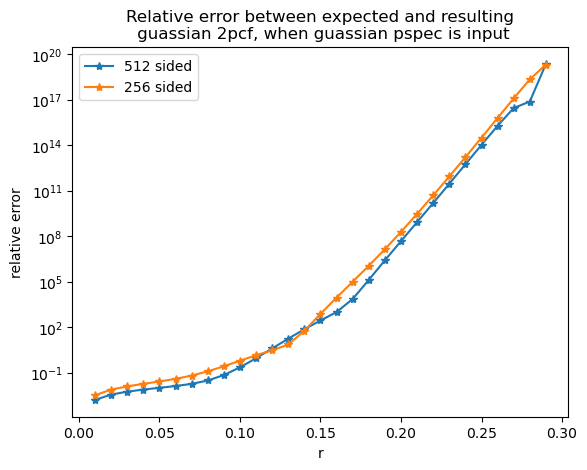

In [9]:
plt.plot(x_intervals_mid_512, error_2pcf_512, '-*', label="512 sided")
plt.plot(x_intervals_mid_256, error_2pcf_256, '-*', label="256 sided")
plt.ylabel('relative error')
plt.xlabel('r')
plt.yscale('log')
plt.title('Relative error between expected and resulting\n guassian 2pcf, when guassian pspec is input')
plt.legend()

In [23]:
npz_files_256 = np.load("Gauss_error_files/_256.npz")
npz_files_512 = np.load("Gauss_error_files/_512.npz")